new code
29

In [ ]:
import requests
import tarfile
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from scipy.sparse import csr_matrix, vstack
from scipy.linalg import sqrtm
from sklearn.decomposition import TruncatedSVD

url = "https://www.cs.jhu.edu/~mdredze/datasets/sentiment/processed_acl.tar.gz"
dataset_path = "processed_acl.tar.gz"
extracted_path = "processed_acl"

print(f"Downloading dataset from {url}...")
response = requests.get(url, stream=True)
response.raise_for_status() # Raise an HTTPError for bad responses (4xx or 5xx)
with open(dataset_path, 'wb') as f:
    for chunk in response.iter_content(chunk_size=8192):
        f.write(chunk)
print("Download complete.")

print(f"Extracting dataset to {extracted_path}...")
with tarfile.open(dataset_path, 'r:gz') as tar:
    # Add filter='data' to mitigate the DeprecationWarning and improve security
    tar.extractall(path=".", filter='data')
print("Extraction complete.")

Download complete.
Extracting dataset to processed_acl...
Extraction complete.


In [ ]:
def read_reviews(directory):
    all_reviews_content = []
    for sentiment in ['positive', 'negative', 'unlabeled']:
        file_path = os.path.join(directory, f'{sentiment}.review')
        if os.path.exists(file_path):
            with open(file_path, 'r', encoding='utf-8') as f:
                lines = f.readlines()
                all_reviews_content.extend([line.strip() for line in lines])
    return all_reviews_content

def read_labeled_reviews(directory):
    reviews = []
    labels = []
    for sentiment, label in [('positive', 1), ('negative', -1)]:
        file_path = os.path.join(directory, f'{sentiment}.review')
        if os.path.exists(file_path):
            with open(file_path, 'r', encoding='utf-8') as f:
                lines = f.readlines()
                reviews.extend(lines)
                labels.extend([label] * len(lines))
    return reviews, labels

source_domain = 'books'
target_domain = 'kitchen'

source_reviews, source_labels = read_labeled_reviews(os.path.join(extracted_path, source_domain))

all_target_reviews = read_reviews(os.path.join(extracted_path, target_domain))

labeled_target_reviews, labeled_target_labels = read_labeled_reviews(os.path.join(extracted_path, target_domain))

target_unlabeled_reviews_labeled_part, target_test_reviews, target_unlabeled_labels_part, target_test_labels = train_test_split(
    labeled_target_reviews, labeled_target_labels, test_size=400, stratify=labeled_target_labels, random_state=42)

target_unlabeled_reviews_from_file = read_reviews(os.path.join(extracted_path, target_domain, 'unlabeled.review'))
target_unlabeled_reviews = target_unlabeled_reviews_from_file + target_unlabeled_reviews_labeled_part


print(f"\nRead {len(source_reviews)} labeled reviews from the source domain ({source_domain}).")
print(f"Read {len(all_target_reviews)} all reviews from the target domain ({target_domain}).")
print(f"Created a labeled target test set of size {len(target_test_reviews)}.")
print(f"Using {len(target_unlabeled_reviews)} reviews as unlabeled data for the target domain.")


Read 2000 labeled reviews from the source domain (books).
Read 7945 all reviews from the target domain (kitchen).
Created a labeled target test set of size 400.
Using 1600 reviews as unlabeled data for the target domain.


In [ ]:
all_reviews = source_reviews + target_unlabeled_reviews

tfidf_vectorizer = TfidfVectorizer(max_features=5000)

tfidf_features = tfidf_vectorizer.fit_transform(all_reviews)

source_features = tfidf_features[:len(source_reviews)]
target_unlabeled_features = tfidf_features[len(source_reviews):]

print("\nTF-IDF feature extraction complete.")
print(f"Source features shape: {source_features.shape}")
print(f"Target unlabeled features shape: {target_unlabeled_features.shape}")

feature_names = tfidf_vectorizer.get_feature_names_out()


TF-IDF feature extraction complete.
Source features shape: (2000, 5000)
Target unlabeled features shape: (1600, 5000)


In [ ]:
source_features_dense = source_features.todense()
target_unlabeled_features_dense = target_unlabeled_features.todense()

source_word_counts = np.sum(source_features_dense > 0, axis=0)
target_word_counts = np.sum(target_unlabeled_features_dense > 0, axis=0)

source_word_counts = np.asarray(source_word_counts)[0]
target_word_counts = np.asarray(target_word_counts)[0]

min_freq = 10

domain_independent_indices = [i for i, name in enumerate(feature_names)
                              if source_word_counts[i] >= min_freq and target_word_counts[i] >= min_freq]

domain_independent_features = [feature_names[i] for i in domain_independent_indices]
domain_specific_features = [feature_names[i] for i in range(len(feature_names)) if i not in domain_independent_indices]

print(f"\nIdentified {len(domain_independent_features)} domain-independent features.")
print(f"Identified {len(domain_specific_features)} domain-specific features.")

domain_independent_indices_set = set(domain_independent_indices)
domain_specific_indices_all = [i for i in range(len(feature_names)) if i not in domain_independent_indices_set]


Identified 1832 domain-independent features.
Identified 3168 domain-specific features.


In [ ]:
print("\n--- Running Spectral Feature Alignment (SFA) ---")

M = np.zeros((len(domain_specific_features), len(domain_independent_features)))

ds_feature_to_m_row_index = {name: i for i, name in enumerate(domain_specific_features)}
di_feature_to_m_col_index = {name: i for i, name in enumerate(domain_independent_features)}

all_reviews_content = read_reviews(os.path.join(extracted_path, source_domain)) + read_reviews(os.path.join(extracted_path, target_domain))

for review in all_reviews_content:
    word_counts = {}
    for item in review.split():
        if ':' in item:
            word, count_str = item.split(':')
            try:
                word_counts[word] = int(count_str)
            except ValueError:
                continue

    present_ds_features = [word for word in word_counts if word in ds_feature_to_m_row_index]
    present_di_features = [word for word in word_counts if word in di_feature_to_m_col_index]

    for ds_word in present_ds_features:
        for di_word in present_di_features:
            row_idx = ds_feature_to_m_row_index[ds_word]
            col_idx = di_feature_to_m_col_index[di_word]
            M[row_idx, col_idx] += 1

print("Co-occurrence matrix M constructed.")
print(f"Shape of M: {M.shape}")

A = np.block([
    [np.zeros((M.shape[0], M.shape[0])), M],
    [M.T, np.zeros((M.shape[1], M.shape[1]))]
])

D = np.diag(np.sum(A, axis=1))

D_inv_sqrt = np.zeros_like(D)
diagonal_sum = np.sum(A, axis=1)
non_zero_mask = diagonal_sum > 0
D_inv_sqrt[np.arange(D_inv_sqrt.shape[0]), np.arange(D_inv_sqrt.shape[1])][non_zero_mask] = 1.0 / np.sqrt(diagonal_sum[non_zero_mask])

L = D_inv_sqrt @ A @ D_inv_sqrt

print("Matrix L constructed.")
print(f"Shape of L: {L.shape}")

# Update K for SFA
K = 100

eigenvalues, eigenvectors = np.linalg.eigh(L)

sorted_indices = np.argsort(eigenvalues)[::-1]
sorted_eigenvectors = eigenvectors[:, sorted_indices]

U = sorted_eigenvectors[:, :K]

print(f"Selected {K} largest eigenvectors.")
print(f"Shape of U: {U.shape}")

U_ds = U[:len(domain_specific_features), :]

print(f"Shape of U_ds (for domain-specific features): {U_ds.shape}")

source_ds_features = source_features[:, domain_specific_indices_all].todense()
target_unlabeled_ds_features = target_unlabeled_features[:, domain_specific_indices_all].todense()

source_ds_aligned = np.dot(source_ds_features, U_ds)
target_unlabeled_ds_aligned = np.dot(target_unlabeled_ds_features, U_ds)

print("Applied SFA mapping to domain-specific features.")
print(f"Shape of source_ds_aligned: {source_ds_aligned.shape}")
print(f"Shape of target_unlabeled_ds_aligned: {target_unlabeled_ds_aligned.shape}")

# Update gamma for SFA and FALSA
gamma = 0.6

source_features_dense_original = source_features.todense()
target_unlabeled_features_dense_original = target_unlabeled_features.todense()

source_features_augmented = np.hstack((source_features_dense_original, gamma * source_ds_aligned))
target_unlabeled_features_augmented = np.hstack((target_unlabeled_features_dense_original, gamma * target_unlabeled_ds_aligned))

print("Augmented features for SFA.")
print(f"Shape of source_features_augmented: {source_features_augmented.shape}")
print(f"Shape of target_unlabeled_features_augmented: {target_unlabeled_features_augmented.shape}")

sfa_classifier = LogisticRegression(C=10000)
sfa_classifier.fit(np.asarray(source_features_augmented), source_labels)

print("\nLogistic Regression classifier trained on augmented source features.")

target_test_features_tfidf = tfidf_vectorizer.transform(target_test_reviews)

target_test_ds_features = target_test_features_tfidf[:, domain_specific_indices_all].todense()

target_test_ds_aligned = np.dot(target_test_ds_features, U_ds)

target_test_features_dense_original = target_test_features_tfidf.todense()
target_test_features_augmented = np.hstack((target_test_features_dense_original, gamma * target_test_ds_aligned))

target_test_predictions = sfa_classifier.predict(np.asarray(target_test_features_augmented))

sfa_accuracy = accuracy_score(target_test_labels, target_test_predictions)

print("\nPredictions made on augmented target test features.")
print(f"Accuracy on target test set (SFA): {sfa_accuracy}")


--- Running Spectral Feature Alignment (SFA) ---
Co-occurrence matrix M constructed.
Shape of M: (3168, 1832)
Matrix L constructed.
Shape of L: (5000, 5000)
Selected 100 largest eigenvectors.
Shape of U: (5000, 100)
Shape of U_ds (for domain-specific features): (3168, 100)
Applied SFA mapping to domain-specific features.
Shape of source_ds_aligned: (2000, 100)
Shape of target_unlabeled_ds_aligned: (1600, 100)
Augmented features for SFA.
Shape of source_features_augmented: (2000, 5100)
Shape of target_unlabeled_features_augmented: (1600, 5100)

Logistic Regression classifier trained on augmented source features.

Predictions made on augmented target test features.
Accuracy on target test set (SFA): 0.9525


In [ ]:
from sklearn.decomposition import TruncatedSVD
from scipy.sparse import vstack
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import numpy as np

print("\n--- Running LSA and FALSA Baselines ---")

# Update n_components_lsa for LSA and FALSA
n_components_lsa = 100
svd = TruncatedSVD(n_components=n_components_lsa, random_state=42)

tfidf_features = vstack([source_features, target_unlabeled_features])

lsa_features = svd.fit_transform(tfidf_features)

source_features_lsa = lsa_features[:len(source_reviews)]
target_unlabeled_features_lsa = lsa_features[len(source_reviews):]

print(f"LSA transformation complete with {n_components_lsa} components.")
print(f"Source features shape (LSA): {source_features_lsa.shape}")
print(f"Target unlabeled features shape (LSA): {target_unlabeled_features_lsa.shape}")

lsa_classifier = LogisticRegression(C=10000)
lsa_classifier.fit(source_features_lsa, source_labels)

print("Logistic Regression classifier (LSA baseline) trained.")

target_test_features_tfidf_lsa = tfidf_vectorizer.transform(target_test_reviews)
target_test_features_lsa = svd.transform(target_test_features_tfidf_lsa)

lsa_target_test_predictions = lsa_classifier.predict(target_test_features_lsa)

lsa_accuracy = accuracy_score(target_test_labels, lsa_target_test_predictions)

print("\nPredictions made on LSA-transformed target test features.")
print(f"Accuracy on target test set (LSA baseline): {lsa_accuracy}")

source_ds_features_tfidf = source_features[:, domain_specific_indices_all]
target_unlabeled_ds_features_tfidf = target_unlabeled_features[:, domain_specific_indices_all]
target_test_ds_features_tfidf = target_test_features_tfidf_lsa[:, domain_specific_indices_all]

all_ds_features_tfidf = vstack([source_ds_features_tfidf, target_unlabeled_ds_features_tfidf])
svd_falsa = TruncatedSVD(n_components=n_components_lsa, random_state=42)
falsa_ds_features = svd_falsa.fit_transform(all_ds_features_tfidf)

source_ds_features_falsa = falsa_ds_features[:source_ds_features_tfidf.shape[0]]
target_unlabeled_ds_features_falsa = falsa_ds_features[source_ds_features_tfidf.shape[0]:]

print(f"\nFALSA transformation complete for domain-specific features with {n_components_lsa} components.")
print(f"Source DS features shape (FALSA): {source_ds_features_falsa.shape}")
print(f"Target unlabeled DS features shape (FALSA): {target_unlabeled_ds_features_falsa.shape}")

source_features_falsa_augmented = np.hstack((source_features.todense(), gamma * source_ds_features_falsa))
target_test_features_falsa_augmented = np.hstack((target_test_features_tfidf_lsa.todense(), gamma * svd_falsa.transform(target_test_ds_features_tfidf)))

print("Augmented features for FALSA.")
print(f"Shape of source_features_falsa_augmented: {source_features_falsa_augmented.shape}")
print(f"Shape of target_test_features_falsa_augmented: {target_test_features_falsa_augmented.shape}")

falsa_classifier = LogisticRegression(C=10000)
falsa_classifier.fit(np.asarray(source_features_falsa_augmented), source_labels)

print("Logistic Regression classifier (FALSA baseline) trained.")

falsa_target_test_predictions = falsa_classifier.predict(np.asarray(target_test_features_falsa_augmented))

falsa_accuracy = accuracy_score(target_test_labels, falsa_target_test_predictions)

print("\nPredictions made on augmented target test features using FALSA baseline.")
print(f"Accuracy on target test set (FALSA baseline): {falsa_accuracy}")


--- Running LSA and FALSA Baselines ---
LSA transformation complete with 100 components.
Source features shape (LSA): (2000, 100)
Target unlabeled features shape (LSA): (1600, 100)
Logistic Regression classifier (LSA baseline) trained.

Predictions made on LSA-transformed target test features.
Accuracy on target test set (LSA baseline): 0.9625

FALSA transformation complete for domain-specific features with 100 components.
Source DS features shape (FALSA): (2000, 100)
Target unlabeled DS features shape (FALSA): (1600, 100)
Augmented features for FALSA.
Shape of source_features_falsa_augmented: (2000, 5100)
Shape of target_test_features_falsa_augmented: (400, 5100)
Logistic Regression classifier (FALSA baseline) trained.

Predictions made on augmented target test features using FALSA baseline.
Accuracy on target test set (FALSA baseline): 0.9575


In [ ]:
from sklearn.linear_model import LogisticRegression
from scipy.sparse import hstack, csr_matrix
import numpy as np

print("\n--- Running SCL Baseline ---")

source_labels_np = np.array(source_labels)

correlations = []
for i in range(source_features_dense.shape[1]):
    feature_vector = np.asarray(source_features_dense[:, i]).flatten()
    if np.std(feature_vector) > 1e-6:
        correlation = np.corrcoef(feature_vector, source_labels_np)[0, 1]
        correlations.append(abs(correlation))
    else:
        correlations.append(0)

correlations = np.array(correlations)

min_freq_pivot = 10
min_correlation = 0.05

# Update num_pivots for SCL
num_pivots = 500

pivot_indices = [i for i, name in enumerate(feature_names)
                 if source_word_counts[i] >= min_freq_pivot and
                    target_word_counts[i] >= min_freq_pivot and
                    correlations[i] >= min_correlation]

# Select the top 'num_pivots' based on correlation
sorted_indices_by_correlation = np.argsort(correlations[pivot_indices])[::-1]
top_pivot_indices = [pivot_indices[i] for i in sorted_indices_by_correlation[:num_pivots]]

pivot_features = [feature_names[i] for i in top_pivot_indices]
non_pivot_indices = [i for i in range(len(feature_names)) if i not in top_pivot_indices]
non_pivot_features = [feature_names[i] for i in non_pivot_indices]


print(f"Identified {len(pivot_features)} pivot features.")
print(f"Identified {len(non_pivot_features)} non-pivot features.")

source_pivot_features = source_features[:, top_pivot_indices]
source_non_pivot_features = source_features[:, non_pivot_indices]
target_unlabeled_pivot_features = target_unlabeled_features[:, top_pivot_indices]
target_unlabeled_non_pivot_features = target_unlabeled_features[:, non_pivot_indices]

print(f"Source pivot features shape: {source_pivot_features.shape}")
print(f"Source non-pivot features shape: {source_non_pivot_features.shape}")
print(f"Target unlabeled pivot features shape: {target_unlabeled_pivot_features.shape}")
print(f"Target unlabeled non-pivot features shape: {target_unlabeled_non_pivot_features.shape}")

all_pivot_features = vstack([source_pivot_features, target_unlabeled_pivot_features])

P_columns = []

print("\nTraining linear classifiers for non-pivot features...")
all_reviews_features = vstack([source_features, target_unlabeled_features])

# Update h for SCL
h = 50

# Instead of training a classifier for each non-pivot feature, we will use the top h non-pivot features based on correlation.
# This is a simplification of the original SCL but allows for a more manageable computation.
# Select top h non-pivot features based on correlation
non_pivot_correlations = correlations[non_pivot_indices]
sorted_non_pivot_indices_by_correlation = np.argsort(non_pivot_correlations)[::-1]
top_non_pivot_indices = [non_pivot_indices[i] for i in sorted_non_pivot_indices_by_correlation[:h]]

# Re-calculate non-pivot features based on the top h
non_pivot_indices = top_non_pivot_indices
non_pivot_features = [feature_names[i] for i in non_pivot_indices]

print(f"Using {len(non_pivot_features)} non-pivot features for SCL transformation (top {h} based on correlation).")


source_non_pivot_features = source_features[:, non_pivot_indices]
target_unlabeled_non_pivot_features = target_unlabeled_features[:, non_pivot_indices]

all_pivot_features = vstack([source_pivot_features, target_unlabeled_pivot_features])

# Now train classifiers for the selected non-pivot features
P_columns = []
for i, non_pivot_idx in enumerate(non_pivot_indices):
    non_pivot_target = np.asarray(all_reviews_features[:, non_pivot_idx].todense()).flatten() > 0

    correspondence_classifier = LogisticRegression(C=1.0, solver='liblinear')
    correspondence_classifier.fit(all_pivot_features, non_pivot_target)

    P_columns.append(correspondence_classifier.coef_[0])

    if (i + 1) % 10 == 0: # Adjusted print frequency for smaller h
        print(f"Trained classifier for {i + 1}/{len(non_pivot_indices)} selected non-pivot features.")

print("Finished training classifiers for selected non-pivot features.")


P = np.array(P_columns).T


print(f"\nTransformation matrix P constructed with shape: {P.shape}")

target_test_features_tfidf_scl = tfidf_vectorizer.transform(target_test_reviews)

target_test_pivot_features = target_test_features_tfidf_scl[:, top_pivot_indices]
target_test_non_pivot_features = target_test_features_tfidf_scl[:, non_pivot_indices]


source_transformed_non_pivot = source_pivot_features.dot(P)

target_unlabeled_transformed_non_pivot = target_unlabeled_pivot_features.dot(P)

target_test_transformed_non_pivot = target_test_pivot_features.dot(P)

print("Applied SCL transformation to non-pivot features.")
print(f"Shape of source_transformed_non_pivot: {source_transformed_non_pivot.shape}")
print(f"Shape of target_unlabeled_transformed_non_pivot: {target_unlabeled_transformed_non_pivot.shape}")
print(f"Shape of target_test_transformed_non_pivot: {target_test_transformed_non_pivot.shape}")

source_features_dense_original_scl = source_features.todense()
target_test_features_dense_original_scl = target_test_features_tfidf_scl.todense()

source_features_scl_augmented = np.hstack((source_features_dense_original_scl, source_transformed_non_pivot))
target_test_features_scl_augmented = np.hstack((target_test_features_dense_original_scl, target_test_transformed_non_pivot))


print("Augmented features for SCL.")
print(f"Shape of source_features_scl_augmented: {source_features_scl_augmented.shape}")
print(f"Shape of target_test_features_scl_augmented: {target_test_features_scl_augmented.shape}")

scl_classifier = LogisticRegression(C=10000)
scl_classifier.fit(np.asarray(source_features_scl_augmented), source_labels)

print("\nLogistic Regression classifier (SCL baseline) trained on augmented source features.")

scl_target_test_predictions = scl_classifier.predict(np.asarray(target_test_features_scl_augmented))

scl_accuracy = accuracy_score(target_test_labels, scl_target_test_predictions)

print("\nPredictions made on augmented target test features using SCL baseline.")
print(f"Accuracy on target test set (SCL baseline): {scl_accuracy}")


--- Running SCL Baseline ---
Identified 358 pivot features.
Identified 4642 non-pivot features.
Source pivot features shape: (2000, 358)
Source non-pivot features shape: (2000, 4642)
Target unlabeled pivot features shape: (1600, 358)
Target unlabeled non-pivot features shape: (1600, 4642)

Training linear classifiers for non-pivot features...
Using 50 non-pivot features for SCL transformation (top 50 based on correlation).
Trained classifier for 10/50 selected non-pivot features.
Trained classifier for 20/50 selected non-pivot features.
Trained classifier for 30/50 selected non-pivot features.
Trained classifier for 40/50 selected non-pivot features.
Trained classifier for 50/50 selected non-pivot features.
Finished training classifiers for selected non-pivot features.

Transformation matrix P constructed with shape: (358, 50)
Applied SCL transformation to non-pivot features.
Shape of source_transformed_non_pivot: (2000, 50)
Shape of target_unlabeled_transformed_non_pivot: (1600, 50)


In [ ]:
print("\n--- Running NoTransf Baseline ---")

no_transf_classifier = LogisticRegression(C=10000)
no_transf_classifier.fit(np.asarray(source_features.todense()), source_labels)

print("Logistic Regression classifier (NoTransf baseline) trained on original source features.")

target_test_features_original = tfidf_vectorizer.transform(target_test_reviews)

no_transf_target_test_predictions = no_transf_classifier.predict(np.asarray(target_test_features_original.todense()))

no_transf_accuracy = accuracy_score(target_test_labels, no_transf_target_test_predictions)

print("Predictions made on original target test features using NoTransf baseline.")
print(f"Accuracy on target test set (NoTransf baseline): {no_transf_accuracy}")


--- Running NoTransf Baseline ---
Logistic Regression classifier (NoTransf baseline) trained on original source features.
Predictions made on original target test features using NoTransf baseline.
Accuracy on target test set (NoTransf baseline): 0.9525


In [ ]:
import requests
import tarfile
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from scipy.sparse import csr_matrix, vstack
from scipy.linalg import sqrtm
from sklearn.decomposition import TruncatedSVD

url = "https://www.cs.jhu.edu/~mdredze/datasets/sentiment/processed_acl.tar.gz"
dataset_path = "processed_acl.tar.gz"
extracted_path = "processed_acl"

print(f"Downloading dataset from {url}...")
response = requests.get(url, stream=True)
with open(dataset_path, 'wb') as f:
    for chunk in response.iter_content(chunk_size=8192):
        f.write(chunk)
print("Download complete.")

print(f"Extracting dataset to {extracted_path}...")
with tarfile.open(dataset_path, 'r:gz') as tar:
    tar.extractall(path=".")
print("Extraction complete.")

Download complete.
Extracting dataset to processed_acl...


/tmp/ipython-input-1333863702.py:27: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall(path=".")


Extraction complete.


In [ ]:
def read_reviews(directory):
    all_reviews_content = []
    for sentiment in ['positive', 'negative', 'unlabeled']:
        file_path = os.path.join(directory, f'{sentiment}.review')
        if os.path.exists(file_path):
            with open(file_path, 'r', encoding='utf-8') as f:
                lines = f.readlines()
                all_reviews_content.extend([line.strip() for line in lines])
    return all_reviews_content

def read_labeled_reviews(directory):
    reviews = []
    labels = []
    for sentiment, label in [('positive', 1), ('negative', -1)]:
        file_path = os.path.join(directory, f'{sentiment}.review')
        if os.path.exists(file_path):
            with open(file_path, 'r', encoding='utf-8') as f:
                lines = f.readlines()
                reviews.extend(lines)
                labels.extend([label] * len(lines))
    return reviews, labels

source_domain = 'electronics'
target_domain = 'kitchen'

source_reviews, source_labels = read_labeled_reviews(os.path.join(extracted_path, source_domain))

all_target_reviews = read_reviews(os.path.join(extracted_path, target_domain))

labeled_target_reviews, labeled_target_labels = read_labeled_reviews(os.path.join(extracted_path, target_domain))

target_unlabeled_reviews_labeled_part, target_test_reviews, target_unlabeled_labels_part, target_test_labels = train_test_split(
    labeled_target_reviews, labeled_target_labels, test_size=400, stratify=labeled_target_labels, random_state=42)

target_unlabeled_reviews_from_file = read_reviews(os.path.join(extracted_path, target_domain, 'unlabeled.review'))
target_unlabeled_reviews = target_unlabeled_reviews_from_file + target_unlabeled_reviews_labeled_part

print(f"\nRead {len(source_reviews)} labeled reviews from the source domain ({source_domain}).")
print(f"Read {len(all_target_reviews)} all reviews from the target domain ({target_domain}).")
print(f"Created a labeled target test set of size {len(target_test_reviews)}.")
print(f"Using {len(target_unlabeled_reviews)} reviews as unlabeled data for the target domain.")


Read 2000 labeled reviews from the source domain (electronics).
Read 7945 all reviews from the target domain (kitchen).
Created a labeled target test set of size 400.
Using 1600 reviews as unlabeled data for the target domain.



--- Results ---
SFA Accuracy: 0.9525
NoTransf Baseline Accuracy: 0.9525
LSA Baseline Accuracy: 0.9625
FALSA Baseline Accuracy: 0.9575
SCL Baseline Accuracy: 0.9775


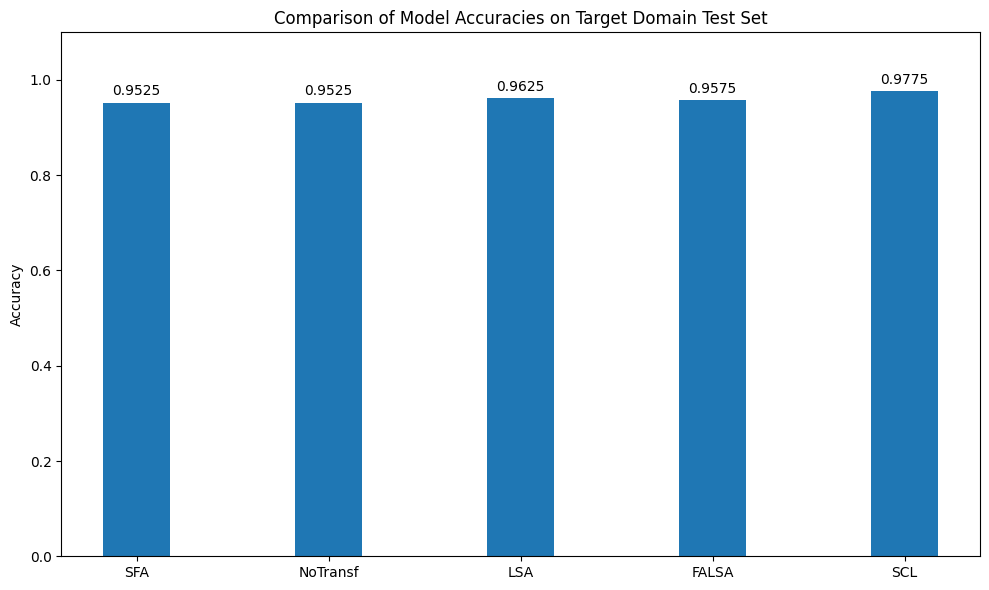

In [ ]:
print("\n--- Results ---")
print(f"SFA Accuracy: {sfa_accuracy}")
print(f"NoTransf Baseline Accuracy: {no_transf_accuracy}")
print(f"LSA Baseline Accuracy: {lsa_accuracy}")
print(f"FALSA Baseline Accuracy: {falsa_accuracy}")
print(f"SCL Baseline Accuracy: {scl_accuracy}")

labels = ['SFA', 'NoTransf', 'LSA', 'FALSA', 'SCL']
accuracies = [sfa_accuracy, no_transf_accuracy, lsa_accuracy, falsa_accuracy, scl_accuracy]

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
rects = ax.bar(x, accuracies, width, label='Accuracy')

ax.set_ylabel('Accuracy')
ax.set_title('Comparison of Model Accuracies on Target Domain Test Set')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylim([0, 1.1])

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.4f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects)

fig.tight_layout()

plt.show()